# **Inside a Latent Space!**
<img src="https://static.wikia.nocookie.net/interstellarfilm/images/3/36/Nl8KjBO_-_Imgur.png/revision/latest?cb=20141115140115" width=50%><br>
**Previosly we developed VAE for MNIST reconstruction**
It was a lot of *fun* and **pain** and we could see the importance of a well-organised latent space.<br>
However, we don't know what is going on in this latent space.<br>
To find out we need to step into it.<br>
Network learns to cluster data in this space encoding features in every dimension.<br>
It's hard to explain it on MNIST, so today we'll work with CelebA dataset - well anotated dataset of celebrety pictures.<br>
One dimension can encode "smile rate", other can encode "glasses rate" and so on.<br>
It means, that we could encode a picture and change one dimension (keeping others fixed) to add or remove features (like glasses or smile).<br>
Soudns cool! Let's roll!

In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CelebA
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import zipfile
from pathlib import Path

zip_path = Path('/content/celeba.zip')
extract_path = Path('/content/data')

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [4]:
from torch.utils.data import Dataset
from PIL import Image
import os
import pandas as pd

class CelebACustomDataset(Dataset):
    def __init__(self, img_dir, attr_path, transform=None):
        self.img_dir = img_dir
        self.attrs = pd.read_csv(attr_path, delim_whitespace=True, skiprows=1)
        self.image_names = self.attrs.index.tolist()
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        attr = self.attrs.loc[img_name].values.astype(int)

        if self.transform:
            image = self.transform(image)

        return image, attr

In [5]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

dataset = CelebACustomDataset(
    img_dir=extract_path / 'celeba' / 'img_align_celeba',
    attr_path=extract_path / 'celeba' / 'list_attr_celeba.txt',
    transform=transform
)

<ipython-input-4-a64fc34addfe>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.attrs = pd.read_csv(attr_path, delim_whitespace=True, skiprows=1)


In [6]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
dataloader

tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1])


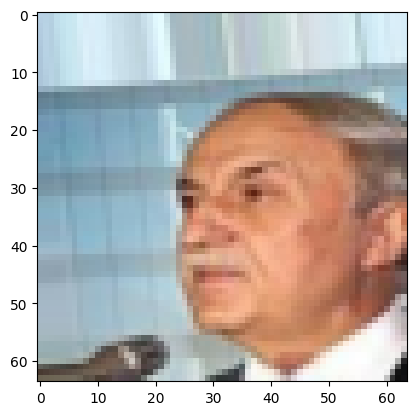

In [7]:
for img_batch, attrs_batch in dataloader:
  img_sample = img_batch[0].permute(1, 2, 0)
  attr_sample = attrs_batch[0]
  print(attr_sample)
  plt.imshow(img_sample);
  break

In [8]:
class ConvVAEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=4, stride=2),  # (B, 8, 31, 31)
        # nn.BatchNorm2d(num_features=8),
        nn.LeakyReLU(0.2),
        nn.Conv2d(16, 32, kernel_size=3, stride=2),  # (B, 16, 15, 15)
        # nn.BatchNorm2d(num_features=16),
        nn.LeakyReLU(0.2),
        nn.Conv2d(32, 64, kernel_size=3, stride=2),  # (B, 32, 7, 7)
        # nn.BatchNorm2d(num_features=32),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, kernel_size=3, stride=2),  # (B, 64, 3, 3)
        nn.Flatten(),
        nn.Linear(128 * 3 * 3, 800),
        nn.LeakyReLU(0.2),
        nn.Linear(800, 400)
    )
    self.mean = nn.Linear(400, 10)
    self.log_var = nn.Linear(400, 10)

  def forward(self, input):
    enc_ = self.encoder(input)
    mean = self.mean(enc_)
    log_var = self.log_var(enc_)
    return mean, log_var

In [9]:
class ConvVAEDecoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.decoder = nn.Sequential(
        nn.Linear(10, 400),
        nn.LeakyReLU(0.2),
        nn.Linear(400, 800),
        nn.LeakyReLU(0.2),
        nn.Linear(800, 128 * 3 * 3),  # (B, 1600)
        nn.Unflatten(1, (128, 3, 3)),
        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),
        # nn.BatchNorm2d(num_features=32),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
        # nn.BatchNorm2d(num_features=16),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2),
        # nn.BatchNorm2d(num_features=8),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2),
        # nn.BatchNorm2d(num_features=1),
        nn.Sigmoid(),
    )

  def forward(self, input):
    return self.decoder(input)

In [10]:
class ConVAE(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, input):
    mean, log_var = self.encoder(input)
    std = torch.exp(0.5 * log_var)
    z = mean + std * torch.randn_like(std)
    rec = self.decoder(z)
    return rec, mean, log_var

In [11]:
epochs = 10

conv_vae_encoder = ConvVAEncoder().to(device)
conv_vae_decoder = ConvVAEDecoder().to(device)
conv_vae = ConVAE(conv_vae_encoder, conv_vae_decoder).to(device)

lr = 0.001
optimizer = optim.Adam(conv_vae.parameters(), lr=lr)
loss_fn = nn.BCELoss()

In [12]:
def kl_div(mean, log_var):
  kl_divergence = -0.5 * torch.sum(1 + log_var - mean**2 - log_var.exp())
  return kl_divergence

Epoch: 0 | Loss: 7241.674863278866


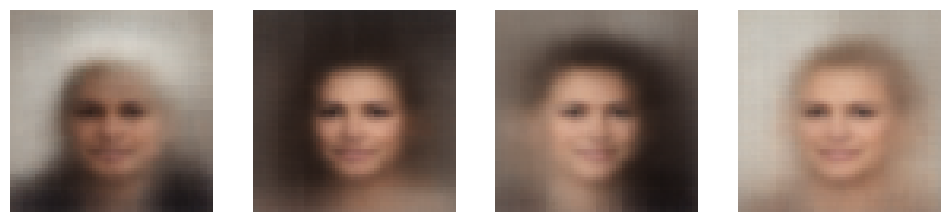

Epoch: 1 | Loss: 7170.121001154184


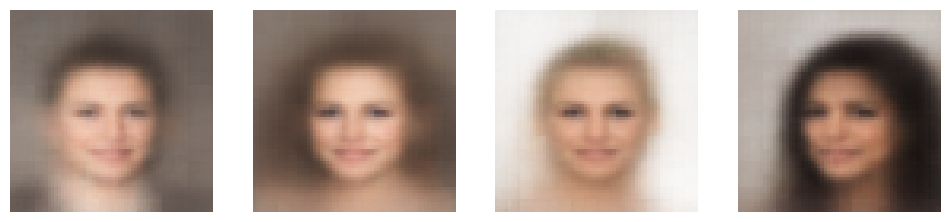

Epoch: 2 | Loss: 7155.697723776102


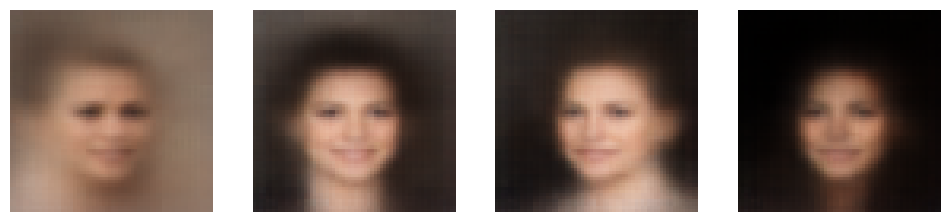

Epoch: 3 | Loss: 7144.047112703323


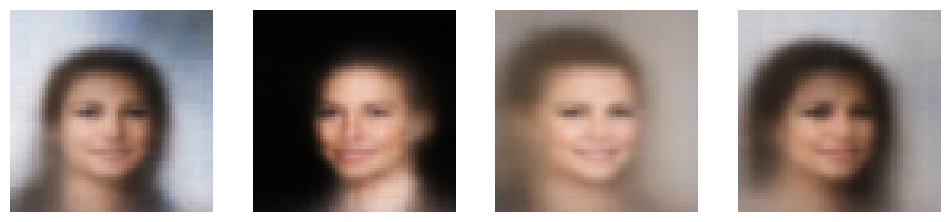

Epoch: 4 | Loss: 7139.431288540363


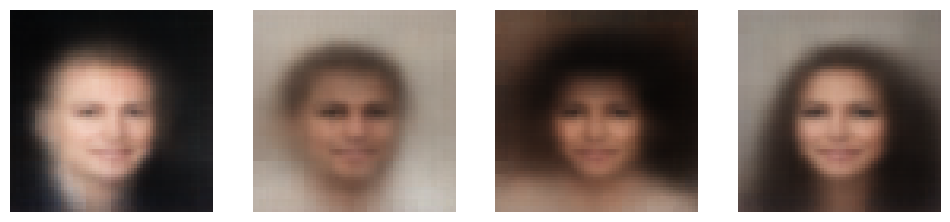

Epoch: 5 | Loss: 7136.762408405542


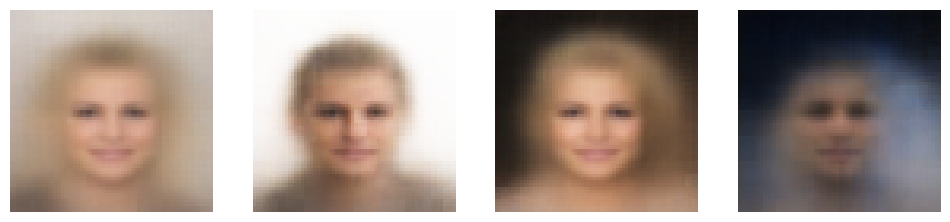

Epoch: 6 | Loss: 7134.730753839016


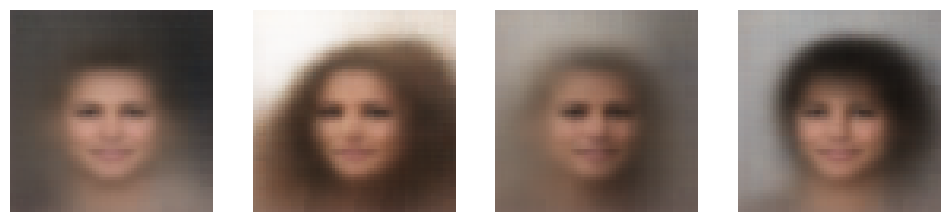

Epoch: 7 | Loss: 7133.163020908833


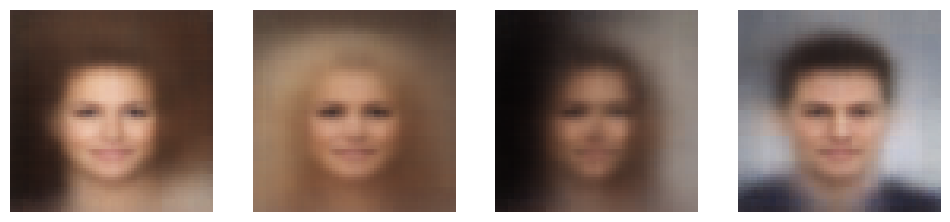

Epoch: 8 | Loss: 7131.812092065811


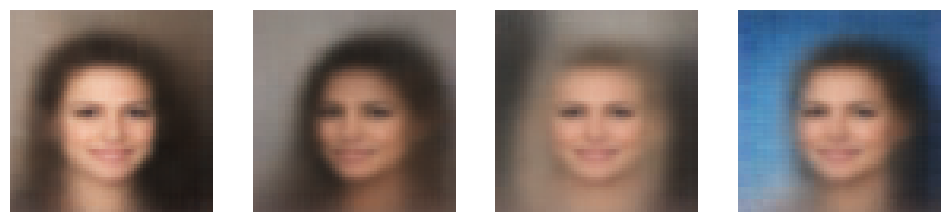

Epoch: 9 | Loss: 7131.129853963852


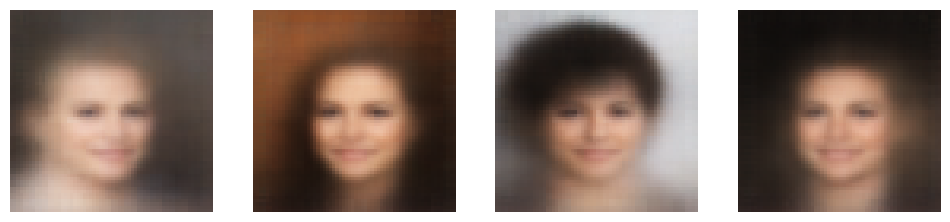

In [13]:
for epoch in range(epochs):
  conv_vae.train()
  epoch_loss = 0
  for img_batch, _ in dataloader:
    img_batch = img_batch.to(device)
    reconstruction, mean, log_var = conv_vae(img_batch)
    bce_loss = loss_fn(reconstruction, img_batch)
    kl_loss = kl_div(mean, log_var)
    batch_loss = bce_loss + 0.0001 * kl_loss
    epoch_loss += batch_loss.item()

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch} | Loss: {epoch_loss}")
  conv_vae.eval()
  with torch.inference_mode():
    noise = torch.randn(4, 10).to(device)
    reconstruction = conv_vae_decoder(noise).to("cpu")
    plt.figure(figsize=(12, 6))
    for n, img in enumerate(reconstruction):
      plt.subplot(1, 4, n+1)
      plt.axis("off")
      plt.imshow(img.permute(1, 2, 0).detach().numpy(), cmap="gray")
    plt.show()

In [14]:
torch.save(conv_vae_encoder.state_dict(), "./encoder_weights.pth")
torch.save(conv_vae_decoder.state_dict(), "./decoder_weights.pth")
torch.save(conv_vae.state_dict(), "./vae_weights.pth")

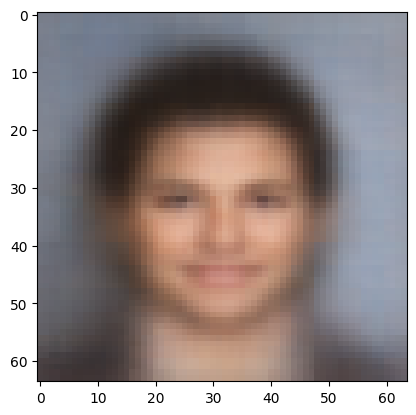

In [36]:
# Okay, our vae is trained, but I'm not gonna use random noise to generate faces
# Our goal today is to tune and tweak latent dims
# So it's okay

conv_vae.eval()
with torch.inference_mode():
  for img_batch, _ in dataloader:
    noise = torch.randn(1, 10).to(device)
    reconstruction = conv_vae_decoder(noise)
    plt.imshow(reconstruction.cpu().squeeze(0).permute(1, 2, 0))
    break

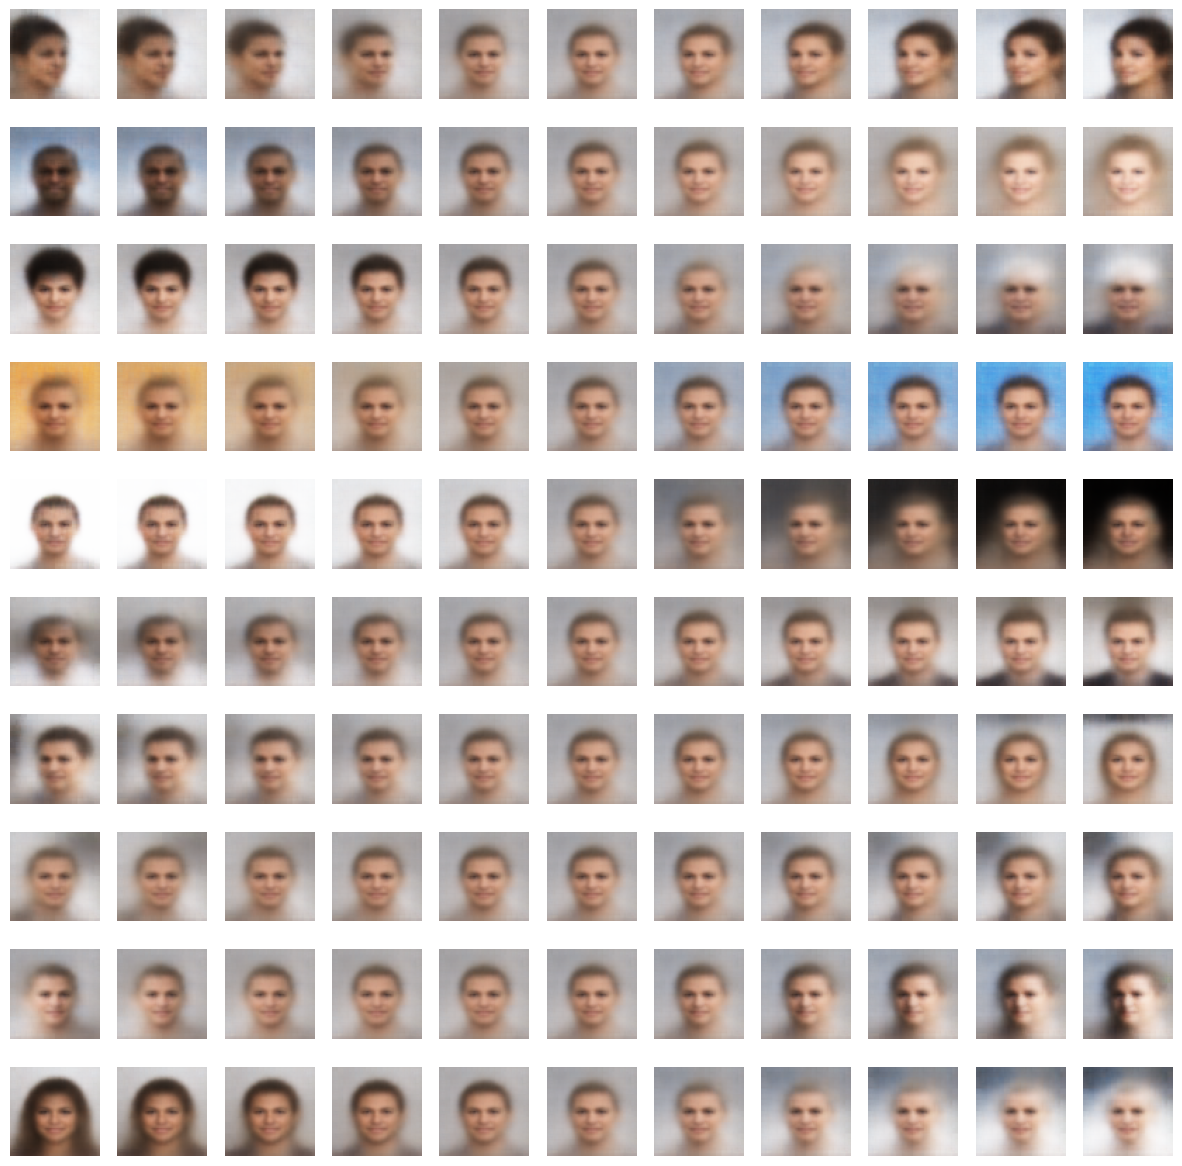

In [49]:
for img, _ in dataloader:
  x = img[0].to(device).unsqueeze(0)
  mean, var = conv_vae_encoder(x)
  break

z = mean[0]

num_steps = 11
alphas = torch.linspace(-3, 3, num_steps)

fig, axes = plt.subplots(10, num_steps, figsize=(15, 15))
for i in range(10):
    for j, alpha in enumerate(alphas):
        z_mod = z.clone()
        z_mod[i] += alpha  # Tune feature
        x_hat = conv_vae_decoder(z_mod.unsqueeze(0))
        image = x_hat.squeeze().detach().cpu().numpy()
        axes[i, j].imshow(torch.tensor(image).permute(1, 2, 0))
        axes[i, j].axis('off')

What did I want to show with this?<br>
I wanted to show how different dimensions store important information.<br>
For example, last row (dimension 10 stores gender, or at least hair length)<br>
1st Row is a roatation feature (isn't it cool, that we can rotate object recreating it from different angles with VAE?)<br>
2nd row shows skin tone feature and so on.<br>
Let's have fun with these, referencing our lookup table.

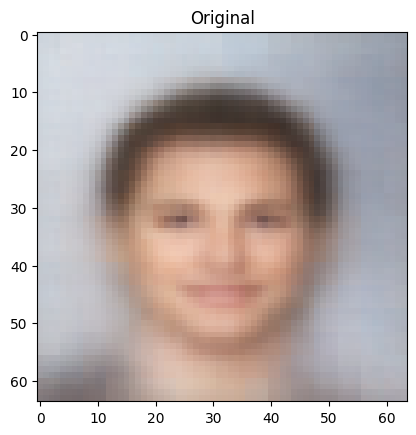

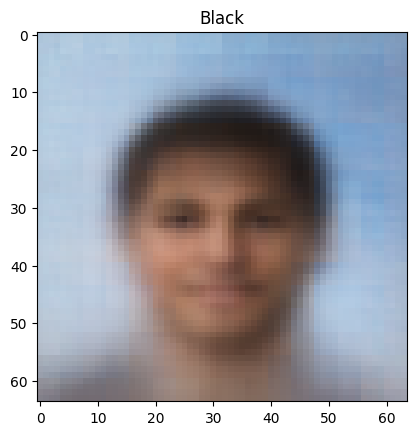

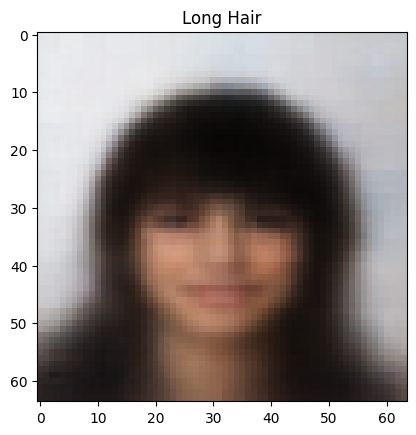

In [62]:
conv_vae.eval()
with torch.inference_mode():
  for img_batch, _ in dataloader:
    noise = torch.randn(1, 10).to(device)
    reconstruction = conv_vae_decoder(noise)
    plt.title("Original")
    plt.imshow(reconstruction.cpu().squeeze(0).permute(1, 2, 0))
    plt.show()
    break

  noise = noise.clone()
  noise.squeeze(0)[1] -= 3
  reconstruction_black = conv_vae_decoder(noise)
  plt.title("Black")
  plt.imshow(reconstruction_black.cpu().squeeze(0).permute(1, 2, 0))
  plt.show()

  noise = noise.clone()
  noise.squeeze(0)[-1] -= 3
  reconstruction_long_hair = conv_vae_decoder(noise)
  plt.title("Long Hair")
  plt.imshow(reconstruction_long_hair.cpu().squeeze(0).permute(1, 2, 0))
  plt.show()

Well... More or less.<br>
This is pretty cool already, but this technique is not really practical.<br>
If we have 100+ dimensions in our latent space (recommended for complex objects) it becomes much harder to find these features.<br>
Btw. Some of the features in our current model are mixed. For example making hair longer makes them darker too (maybe due to dataset specifics) and longer hair automatically changes gender.<br>
This is the problem of 10 dimensions only - not enough to capture everything.<br>

# **Approach with Logistic Regression**
It's pretty simple, we train VAE, then we form a dataset with binary labels (for example, with_glasses-1, without_glasses-0) and fit logistic regression on it.<br>
Logistic regression fits hyperplane and applies sigmoid to it.<br>
We could simply add or subtract this hyperplane to add or remove glasses.<br>

In [63]:
# =============RETRAIN VAE==================

In [64]:
class ConvVAEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=4, stride=2),  # (B, 8, 31, 31)
        # nn.BatchNorm2d(num_features=8),
        nn.LeakyReLU(0.2),
        nn.Conv2d(16, 32, kernel_size=3, stride=2),  # (B, 16, 15, 15)
        # nn.BatchNorm2d(num_features=16),
        nn.LeakyReLU(0.2),
        nn.Conv2d(32, 64, kernel_size=3, stride=2),  # (B, 32, 7, 7)
        # nn.BatchNorm2d(num_features=32),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, kernel_size=3, stride=2),  # (B, 64, 3, 3)
        nn.Flatten(),
        nn.Linear(128 * 3 * 3, 800),
        nn.LeakyReLU(0.2),
        nn.Linear(800, 400)
    )
    self.mean = nn.Linear(400, 100)
    self.log_var = nn.Linear(400, 100)

  def forward(self, input):
    enc_ = self.encoder(input)
    mean = self.mean(enc_)
    log_var = self.log_var(enc_)
    return mean, log_var

In [65]:
class ConvVAEDecoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.decoder = nn.Sequential(
        nn.Linear(100, 400),
        nn.LeakyReLU(0.2),
        nn.Linear(400, 800),
        nn.LeakyReLU(0.2),
        nn.Linear(800, 128 * 3 * 3),  # (B, 1600)
        nn.Unflatten(1, (128, 3, 3)),
        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),
        # nn.BatchNorm2d(num_features=32),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
        # nn.BatchNorm2d(num_features=16),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2),
        # nn.BatchNorm2d(num_features=8),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2),
        # nn.BatchNorm2d(num_features=1),
        nn.Sigmoid(),
    )

  def forward(self, input):
    return self.decoder(input)

In [66]:
class ConVAE(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, input):
    mean, log_var = self.encoder(input)
    std = torch.exp(0.5 * log_var)
    z = mean + std * torch.randn_like(std)
    rec = self.decoder(z)
    return rec, mean, log_var

In [67]:
epochs = 10

conv_vae_encoder = ConvVAEncoder().to(device)
conv_vae_decoder = ConvVAEDecoder().to(device)
conv_vae = ConVAE(conv_vae_encoder, conv_vae_decoder).to(device)

lr = 0.001
optimizer = optim.Adam(conv_vae.parameters(), lr=lr)
loss_fn = nn.BCELoss()

Epoch: 0 | Loss: 7277.630521953106


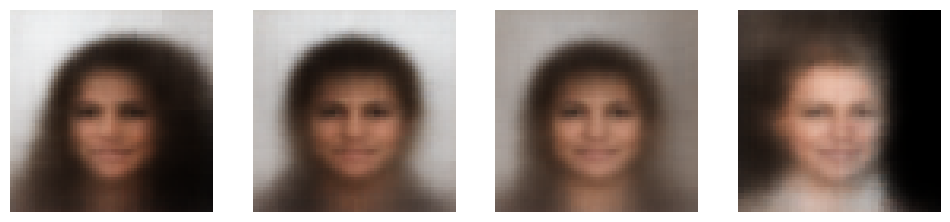

Epoch: 1 | Loss: 7167.937085330486


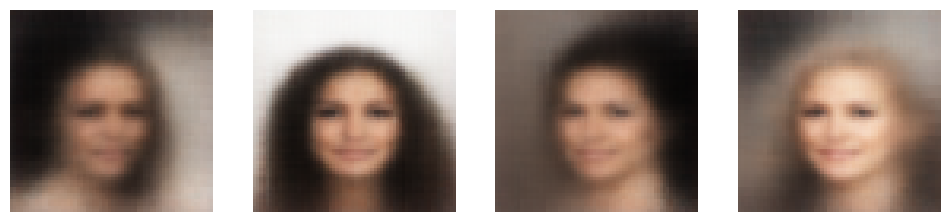

Epoch: 2 | Loss: 7143.251021772623


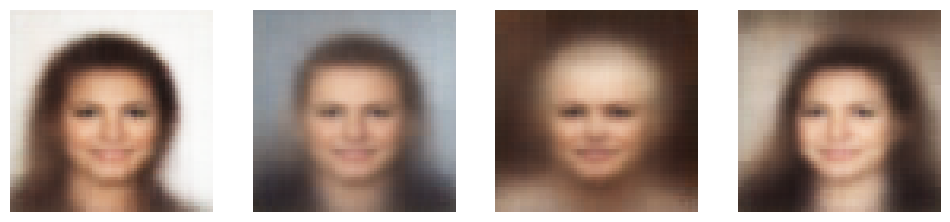

Epoch: 3 | Loss: 7127.913752198219


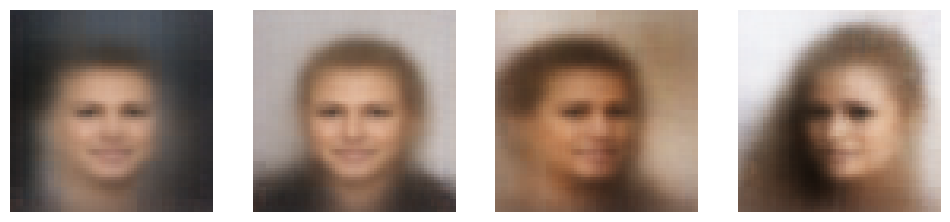

Epoch: 4 | Loss: 7122.012917071581


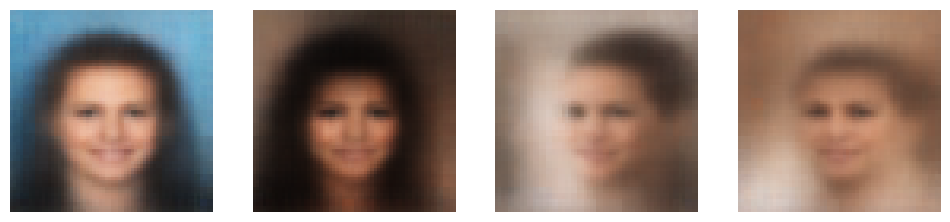

Epoch: 5 | Loss: 7117.95823007822


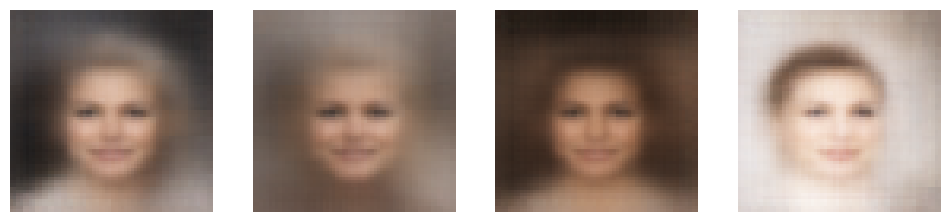

Epoch: 6 | Loss: 7115.079045563936


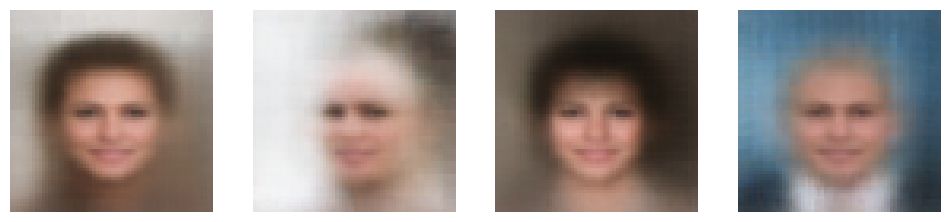

Epoch: 7 | Loss: 7113.044653624296


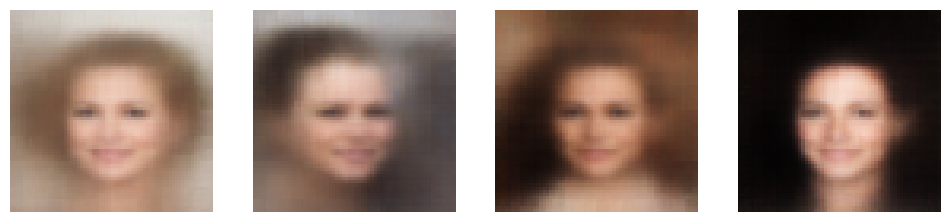

Epoch: 8 | Loss: 7111.071924865246


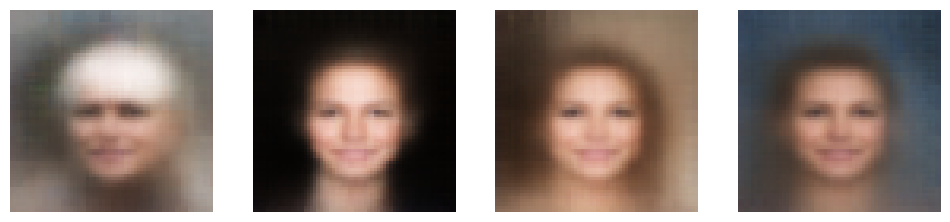

Epoch: 9 | Loss: 7109.775472044945


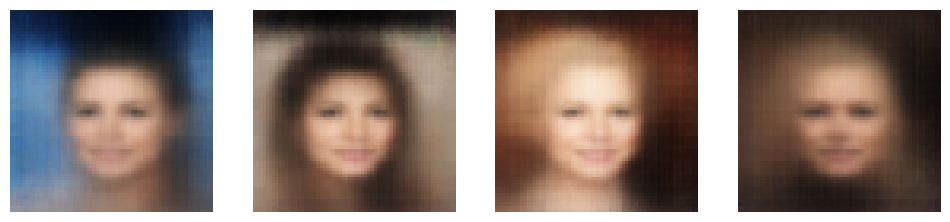

In [68]:
for epoch in range(epochs):
  conv_vae.train()
  epoch_loss = 0
  for img_batch, _ in dataloader:
    img_batch = img_batch.to(device)
    reconstruction, mean, log_var = conv_vae(img_batch)
    bce_loss = loss_fn(reconstruction, img_batch)
    kl_loss = kl_div(mean, log_var)
    batch_loss = bce_loss + 0.0001 * kl_loss
    epoch_loss += batch_loss.item()

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch} | Loss: {epoch_loss}")
  conv_vae.eval()
  with torch.inference_mode():
    noise = torch.randn(4, 100).to(device)
    reconstruction = conv_vae_decoder(noise).to("cpu")
    plt.figure(figsize=(12, 6))
    for n, img in enumerate(reconstruction):
      plt.subplot(1, 4, n+1)
      plt.axis("off")
      plt.imshow(img.permute(1, 2, 0).detach().numpy(), cmap="gray")
    plt.show()

### btw some of these remind me HL2 citizens.<br>
<img src="https://static.wikia.nocookie.net/half-life/images/1/1f/Citizens_infobox.jpg/revision/latest?cb=20110330223440&path-prefix=en" width=50%>

In [74]:
from sklearn.linear_model import LogisticRegression
import numpy as np

latent_vecs = []
labels = []

conv_vae.eval()

with torch.inference_mode():
  for img_batch, attrs_batch in dataloader:
    images = img_batch.to(device)
    glasses_labels = attrs_batch[:, 31].to(device)  # "Smiling feature"

    mu, _ = conv_vae_encoder(images)

    latent_vecs.append(mu.cpu().numpy())
    labels.append(glasses_labels.cpu().numpy())

latent_vecs = np.concatenate(latent_vecs, axis=0)
labels = np.concatenate(labels, axis=0)

In [75]:
clf = LogisticRegression(max_iter=1000)
clf.fit(latent_vecs, labels)

LogisticRegression(max_iter=1000)

In [76]:
attribute_vec = clf.coef_[0]

In [83]:
image, label = dataset[52]
image = image.unsqueeze(0).to(device)

mu, _ = conv_vae_encoder(image)
z = mu

alphas = np.linspace(-1, 1, 7)

recons = []

for alpha in alphas:
  z_mod = z + alpha * torch.tensor(attribute_vec, dtype=torch.float32).to(device)
  x_hat = conv_vae_decoder(z_mod)
  recons.append(x_hat.squeeze().cpu().detach().numpy())

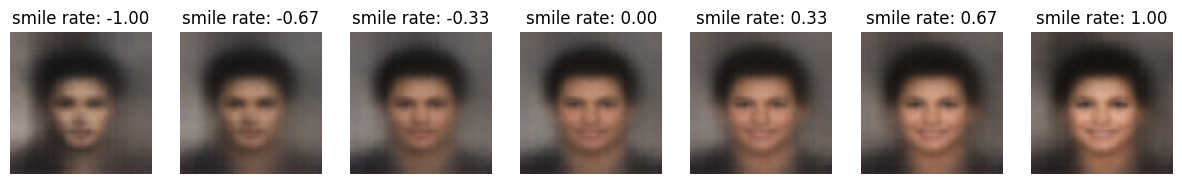

In [94]:
plt.figure(figsize=(15, 10))
for i, recon in enumerate(recons):
  plt.subplot(1, 7, i+1)
  plt.title(f"smile rate: {alphas[i]:.2f}")
  plt.axis("off")
  plt.imshow(torch.tensor(recon).permute(1, 2, 0));

# INSANE!!!!
Let's do more!

In [107]:
from sklearn.linear_model import LogisticRegression
import numpy as np

latent_vecs = []
labels = []

conv_vae.eval()

with torch.inference_mode():
  for img_batch, attrs_batch in dataloader:
    images = img_batch.to(device)
    glasses_labels = attrs_batch[:, 22].to(device)  # "Eyeglasses"

    mu, _ = conv_vae_encoder(images)

    latent_vecs.append(mu.cpu().numpy())
    labels.append(glasses_labels.cpu().numpy())

latent_vecs = np.concatenate(latent_vecs, axis=0)
labels = np.concatenate(labels, axis=0)

In [108]:
clf = LogisticRegression(max_iter=1000)
clf.fit(latent_vecs, labels)

LogisticRegression(max_iter=1000)

In [109]:
attribute_vec = clf.coef_[0]

In [112]:
image, label = dataset[52]
image = image.unsqueeze(0).to(device)

mu, _ = conv_vae_encoder(image)
z = mu

alphas = np.linspace(-3, 3, 7)

recons = []

for alpha in alphas:
  z_mod = z + alpha * torch.tensor(attribute_vec, dtype=torch.float32).to(device)
  x_hat = conv_vae_decoder(z_mod)
  recons.append(x_hat.squeeze().cpu().detach().numpy())

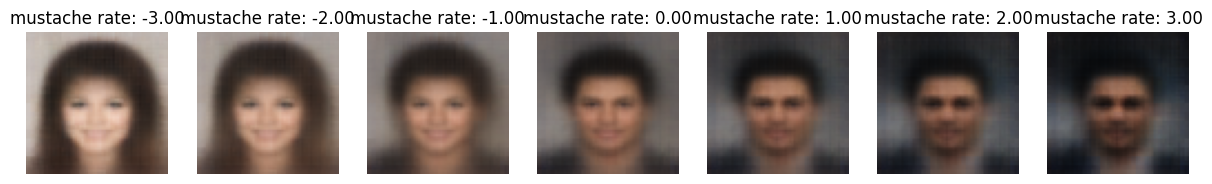

In [114]:
plt.figure(figsize=(15, 10))
for i, recon in enumerate(recons):
  plt.subplot(1, 7, i+1)
  plt.title(f"mustache rate: {alphas[i]:.2f}")
  plt.axis("off")
  plt.imshow(torch.tensor(recon).permute(1, 2, 0));

Oh...<br>
Yep, our VAE is not ideal and it's many miscorrelations.<br>
Only men have mustache and our VAE is not powerfull/trained enough to capture such subtle details.<br>
It's simply no mustache dimension

In [116]:
from sklearn.linear_model import LogisticRegression
import numpy as np

latent_vecs = []
labels = []

conv_vae.eval()

with torch.inference_mode():
  for img_batch, attrs_batch in dataloader:
    images = img_batch.to(device)
    glasses_labels = attrs_batch[:, 4].to(device)  # "Bald"

    mu, _ = conv_vae_encoder(images)

    latent_vecs.append(mu.cpu().numpy())
    labels.append(glasses_labels.cpu().numpy())

latent_vecs = np.concatenate(latent_vecs, axis=0)
labels = np.concatenate(labels, axis=0)

In [117]:
clf = LogisticRegression(max_iter=1000)
clf.fit(latent_vecs, labels)

LogisticRegression(max_iter=1000)

In [118]:
attribute_vec = clf.coef_[0]

In [119]:
image, label = dataset[52]
image = image.unsqueeze(0).to(device)

mu, _ = conv_vae_encoder(image)
z = mu

alphas = np.linspace(-3, 3, 7)

recons = []

for alpha in alphas:
  z_mod = z + alpha * torch.tensor(attribute_vec, dtype=torch.float32).to(device)
  x_hat = conv_vae_decoder(z_mod)
  recons.append(x_hat.squeeze().cpu().detach().numpy())

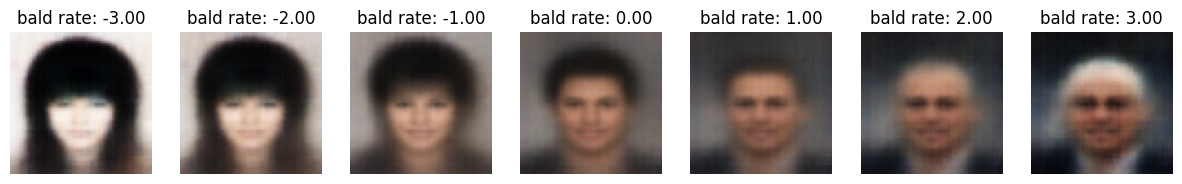

In [121]:
plt.figure(figsize=(15, 10))
for i, recon in enumerate(recons):
  plt.subplot(1, 7, i+1)
  plt.title(f"bald rate: {alphas[i]:.2f}")
  plt.axis("off")
  plt.imshow(torch.tensor(recon).permute(1, 2, 0));

**Nice, but again, additional changes in gender (not needed)**

# **Conclusion**
Finishing with VAEs I want to say it's a really really cool idea.<br>
Coolness of idea is effect it gives over complexity of it.<br>
VAE has so many cool effects (it's widely used for denoising and other tasks) and it's a really simple idea.<br>
Also VAE for beginner is an awesome sandbox to play at!<br>
If someone reads this text (hey there) I recommend you to try it yourself.<br>
It's just so cool!<br>
**Coolness rate: 95%**
<br>
<img src="https://static.wikia.nocookie.net/cyberpunk/images/d/de/Johnny_Silverhand_Database_CP2077.png/revision/latest?cb=20231003222545" width=13%>